# Improved Data Visualization and Model Training for NAVAR_TCN_EPISTEMIC

In [1]:
import sys

# Add the project directory to the sys.path
sys.path.append("../")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import trange

from src.models.navar.navar_epistemic import NAVAR_TCN_DER, NAVAR_TCN_SDER, loss_der, loss_sder
from scripts.experiments.remember_noise_test_epistemic import generate_random_data, train_model, post_training_analysis
from src.utils.pytorch import count_parameters
from src.utils.visualisations import smooth_line

C:\Users\mauri\anaconda3\envs\causal-discovery\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
type = 'SDER'

if type == 'DER':
    model_type = NAVAR_TCN_DER
    loss_function = loss_der
else:
    model_type = NAVAR_TCN_SDER
    loss_function = loss_sder


## Data Preparation

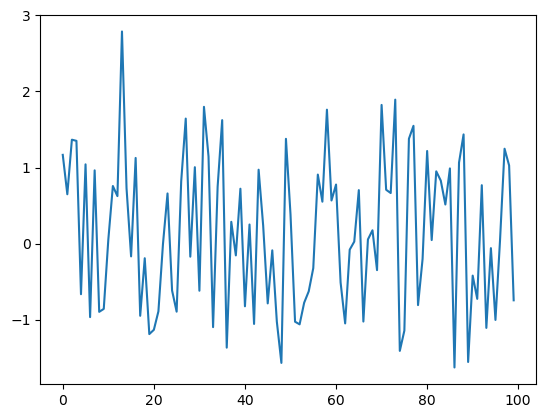

In [3]:
x_train, y_train, true_function_train = generate_random_data(sequence_length=2500)

if torch.cuda.is_available():
    x_train, y_train, true_function_train = x_train.cuda(), y_train.cuda(), true_function_train.cuda()

plt.plot(x_train[0, 1, :100].cpu())

## Model Training

In [8]:
model = model_type(n_variables=3, hidden_dim=12, kernel_size=2, n_blocks=1, n_layers_per_block=2, dropout=0.0)
print(model)

if torch.cuda.is_available():
    model = model.cuda()

print('n_parameters per var:', count_parameters(model) // 3)
print('receptive field:', model.receptive_field)

model = train_model(model, x_train, y_train, loss_function, epochs=2000, lr=1e-3, coeff_start=1e-1, coeff_end=1e-1)

x, y, true_function, gamma, v, alpha, beta, aleatoric, epistemic = post_training_analysis(model, x_train, y_train, true_function_train, from_var=0, to_var=1)

NAVAR_TCN_SDER(
  (contributions): BaseTCN(
    (relu): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
    (temporal_blocks): ModuleList(
      (0): TemporalBlock(
        (dropout): Dropout(p=0.0, inplace=False)
        (relu): ReLU()
        (convolutions): ModuleList(
          (0): Conv1d(3, 36, kernel_size=(2,), stride=(1,), groups=3)
          (1): Conv1d(36, 36, kernel_size=(2,), stride=(1,), groups=3)
        )
        (normalizations): ModuleList(
          (0): GroupNorm(3, 36, eps=1e-05, affine=True)
          (1): GroupNorm(3, 36, eps=1e-05, affine=True)
        )
        (down_sample): DownSample(
          (conv): Conv1d(3, 36, kernel_size=(1,), stride=(1,), groups=3, bias=False)
          (group_norm): GroupNorm(3, 36, eps=1e-05, affine=True)
        )
      )
    )
    (predictions): Conv1d(36, 9, kernel_size=(1,), stride=(1,), groups=3)
  )
  (beta_v): BaseTCN(
    (relu): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
    (temporal_blocks): ModuleList(
     

Loss: -0.7540: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 74.00it/s]


## Data Visualization

plot empistemic uncertainty


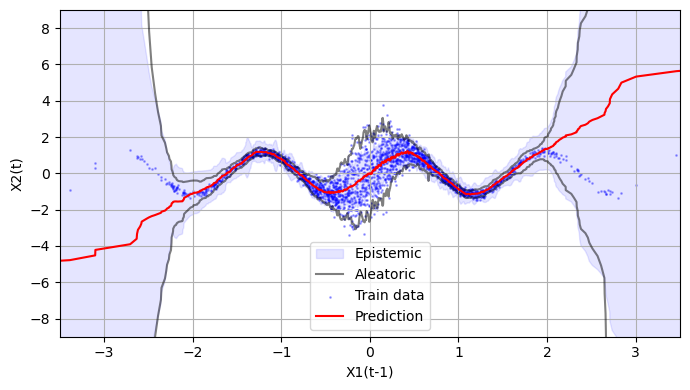

In [9]:
gamma_smooth = smooth_line(gamma, 4.0)
aleatoric_smooth = smooth_line(aleatoric, 6.0)
epistemic_smooth = smooth_line(epistemic, 6.0)

fig, ax = plt.subplots(figsize=(7, 4))

# Plotting the true function
plt.grid(True)

# epistemic
plt.fill_between(x, gamma_smooth - 0.1 * epistemic_smooth, gamma_smooth + 0.1 * epistemic_smooth, color='blue', alpha=0.1, label='Epistemic')
# aleatoric
plt.plot(x, gamma_smooth - 2 * aleatoric_smooth, color='black', alpha=0.5, label='Aleatoric')
plt.plot(x, gamma_smooth + 2 * aleatoric_smooth, color='black', alpha=0.5)
# true function
#plt.plot(x, true_function, label='True Function', color='blue', alpha=1.0)
# train data
plt.scatter(x, y, color='blue', marker='o', s=1, label='Train data', alpha=0.3)
# prediction
plt.plot(x, gamma_smooth, label='Prediction', color='red', alpha=1.0)



plt.xlim([-3.5, 3.5])
plt.ylim([-9, 9])
plt.xlabel("X1(t-1)")
plt.ylabel("X2(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("C:/Users/mauri/Desktop/thesis_img/uncertainty_relationship.svg", format='svg')

plot time series

(-2.2, 2.2)

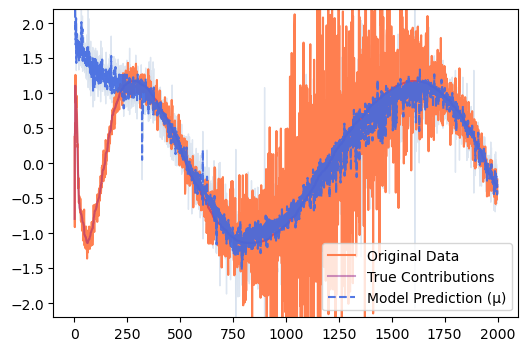

In [6]:
a, b = 1, 2000
y_ticks = np.arange(a, b, 1)

plt.figure(figsize=(6, 4))  # adjust the size for better visualization
plt.plot(y_ticks, y[a:b], label="Original Data", alpha=1.0, zorder=0, color='coral')

plt.plot(y_ticks, true_function[a+1:b+1], label="True Contributions", alpha=0.4, zorder=1, color='purple')

plt.plot(y_ticks, gamma[a:b], label="Model Prediction (μ)", linestyle='dashed', alpha=0.9, zorder=1, color='royalblue')

# Plotting standard deviations
plt.fill_between(y_ticks, gamma[a:b] - 0.1 * epistemic[a:b], gamma[a:b] + 0.1 * epistemic[a:b], color='lightsteelblue', alpha=0.4, zorder=-2)

plt.legend()
plt.ylim
plt.ylim([-2.2, 2.2])

plot paramters

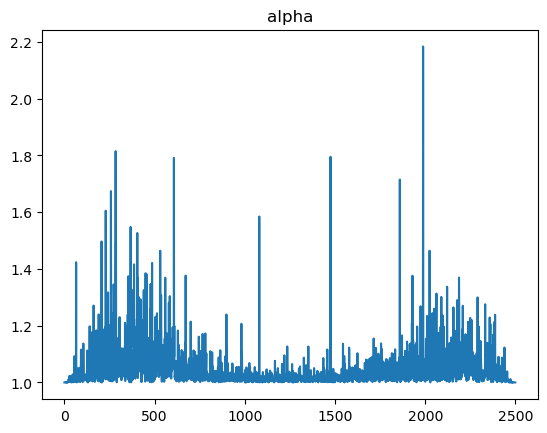

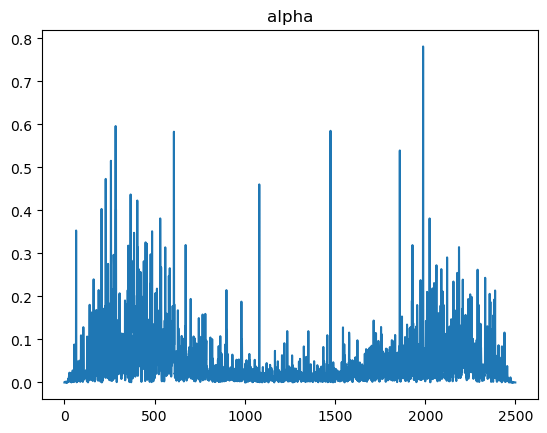

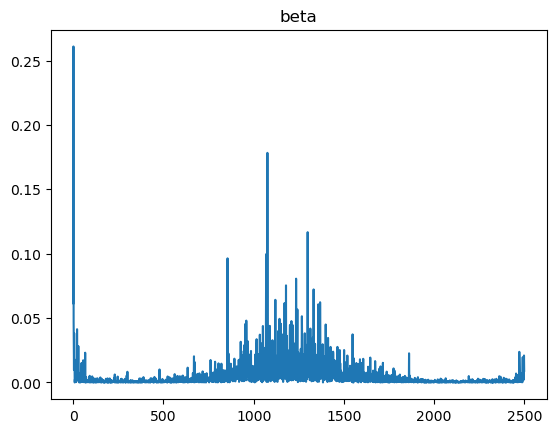

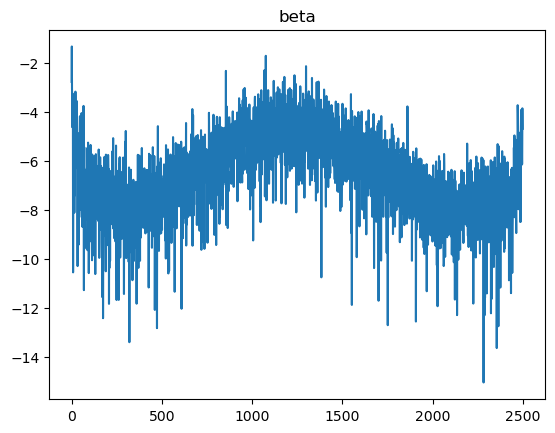

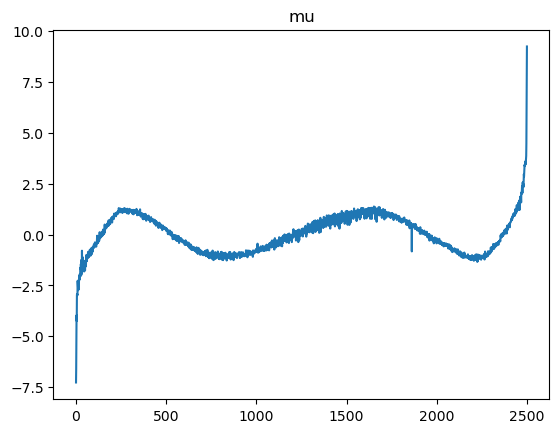

C:\Users\mauri\AppData\Local\Temp\ipykernel_4280\3622460279.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(d))


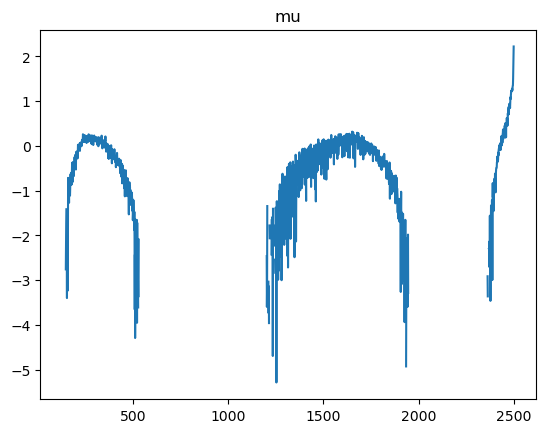

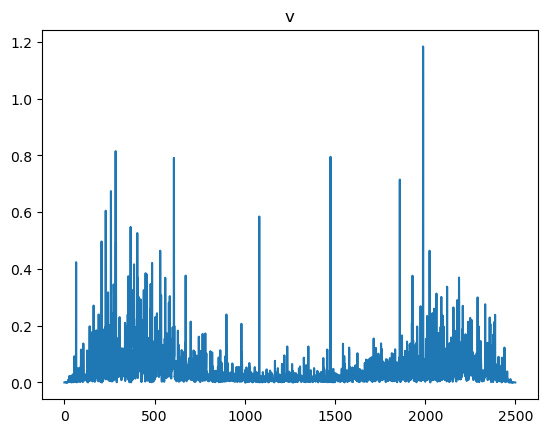

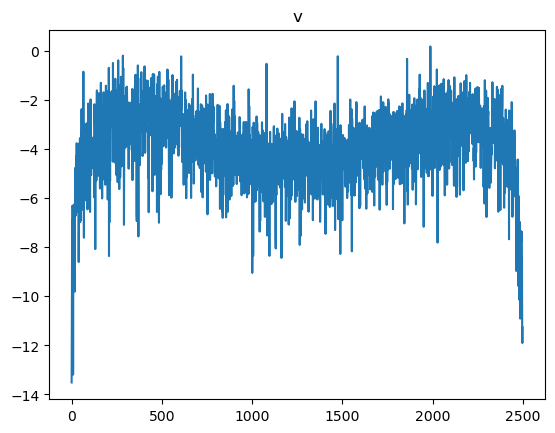

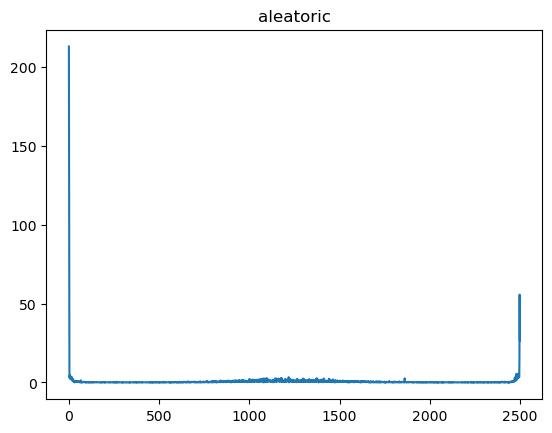

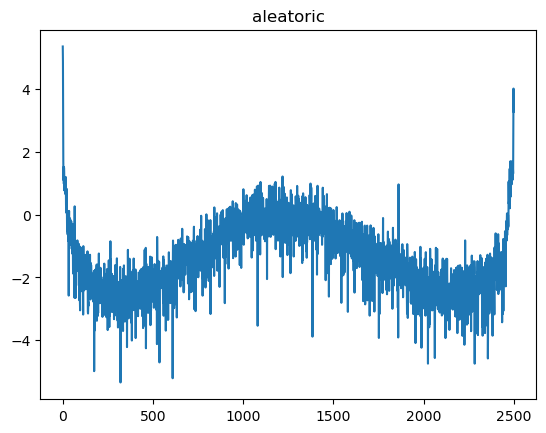

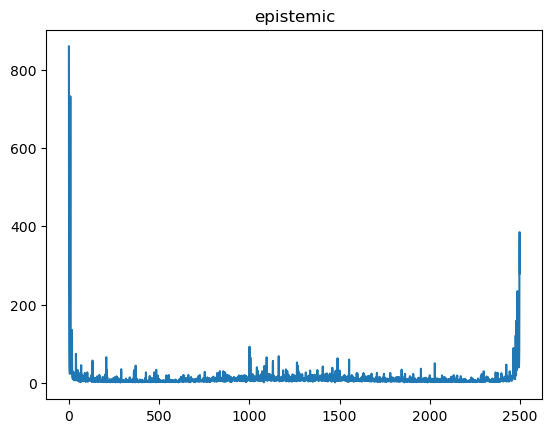

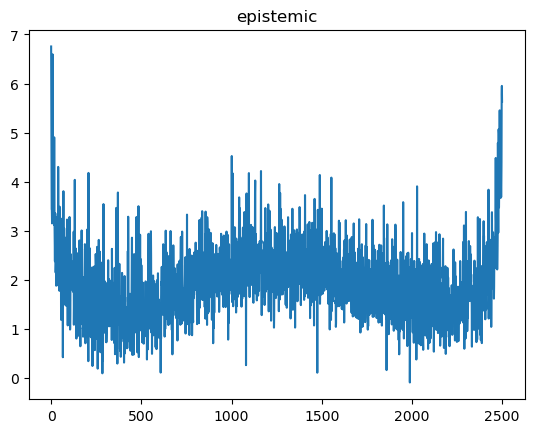

In [13]:
for d, name in [(alpha, 'alpha'), (beta, 'beta'), (gamma, 'mu'), (v, 'v'), (aleatoric, 'aleatoric'), (epistemic, 'epistemic')]:
    plt.clf()
    k = len(d)
    #plt.plot(d[int(0.30 * len(d)): int(0.70 * len(d))])
    plt.plot(d)
    plt.title(name)
    plt.show()
    plt.plot(np.log(d))
    plt.title(name)
    plt.show()